**Job title frequency for job levels**

By: PodiPeti

In [29]:
import pandas as pd
import json
from collections import Counter
from nltk import bigrams, trigrams
from itertools import chain
from wordcloud import WordCloud
import matplotlib.pyplot as plt

INPUT

In [30]:
df = pd.read_csv('input/preprocessed_jobs_all.csv')                 # tokenized, lemmatized, replaced, filtered

with open('input/style.json', 'r') as json_file:
    style = json.load(json_file)

GENERATING N-GRAMS

In [31]:
def get_ngrams(titles, n):
    if n == 1:
        return [word for title in titles for word in title.split()]
    elif n == 2:
        return list(chain.from_iterable(bigrams(title.split()) for title in titles))
    elif n == 3:
        return list(chain.from_iterable(trigrams(title.split()) for title in titles))
    else:
        raise ValueError("n should be 1, 2, 3")
    


CREATING WORD CLOUD

In [32]:
# cutsom font color
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return style['colors'][level]

In [33]:
def create_wordcloud(word_freq, level, ngram_type):
    # Convert the Counter object to a dictionary
    word_freq_dict = {str(gram): freq for gram, freq in word_freq.items()}

    wordcloud = WordCloud(
        width=800, height=1200,
        background_color='white',
        font_path=style['font_path'],
        color_func=custom_color_func
    ).generate_from_frequencies(word_freq_dict)
                       
    plt.figure(figsize = (8, 12), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.savefig(f'figures/title/title_freq_{level}_{ngram_type}_wordcloud.png')

SAVE TO EXCEL

In [34]:
def save_excel(frequencies, level, ngram_type, excel_writer):
    df = pd.DataFrame(frequencies.items(), columns=[ngram_type, 'Frequency'])
    if ngram_type != 'unigram':
        df[ngram_type] = df[ngram_type].apply(lambda x: ' '.join(x))
    df.sort_values(by='Frequency', ascending=False, inplace=True)
    df.to_excel(excel_writer, sheet_name=f'{level}_{ngram_type}', index=False)

PROCESS AND CALL FUNCTIONS

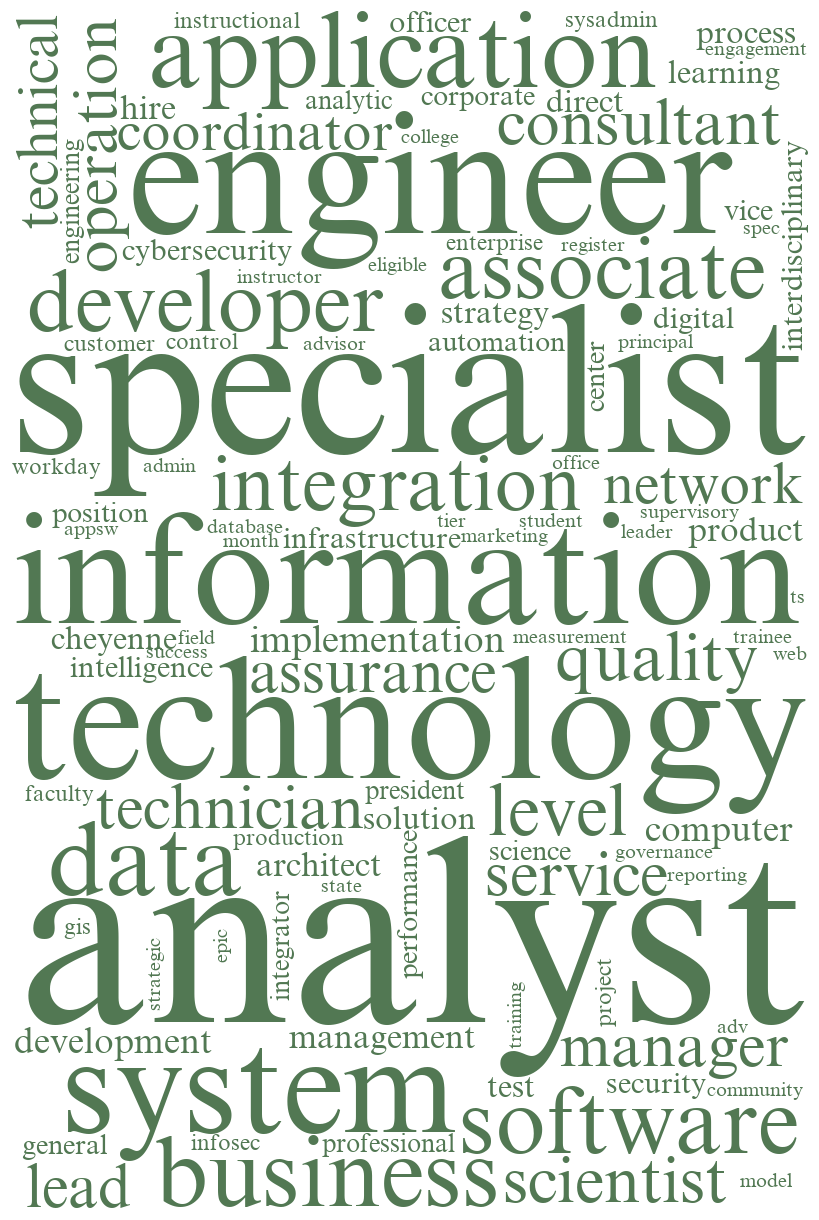

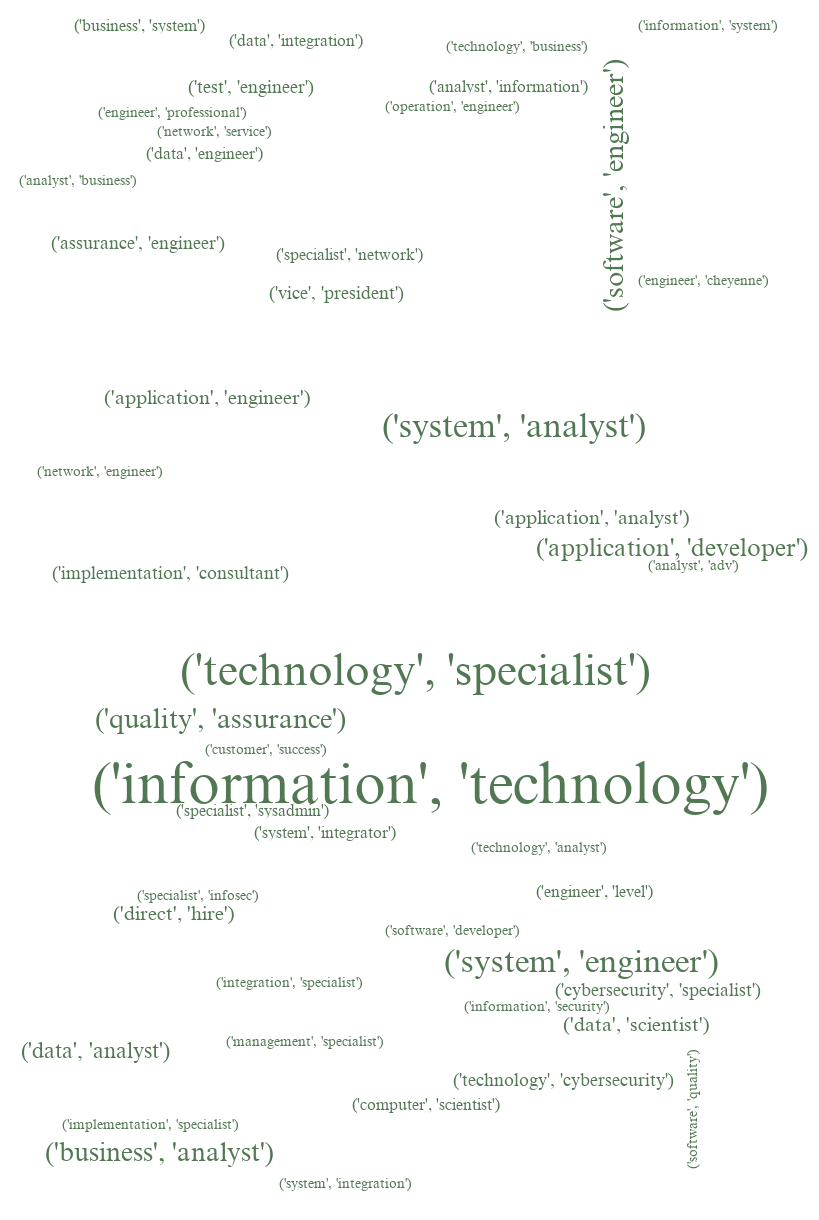

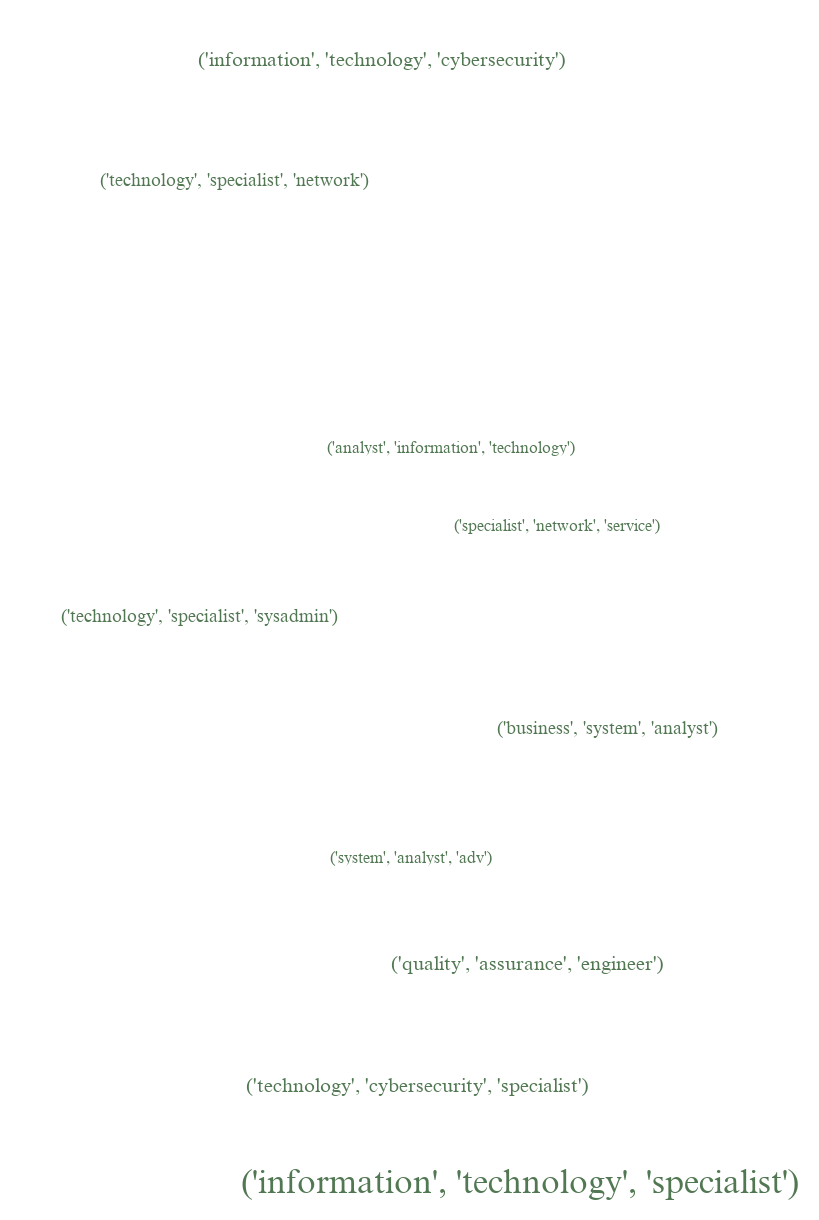

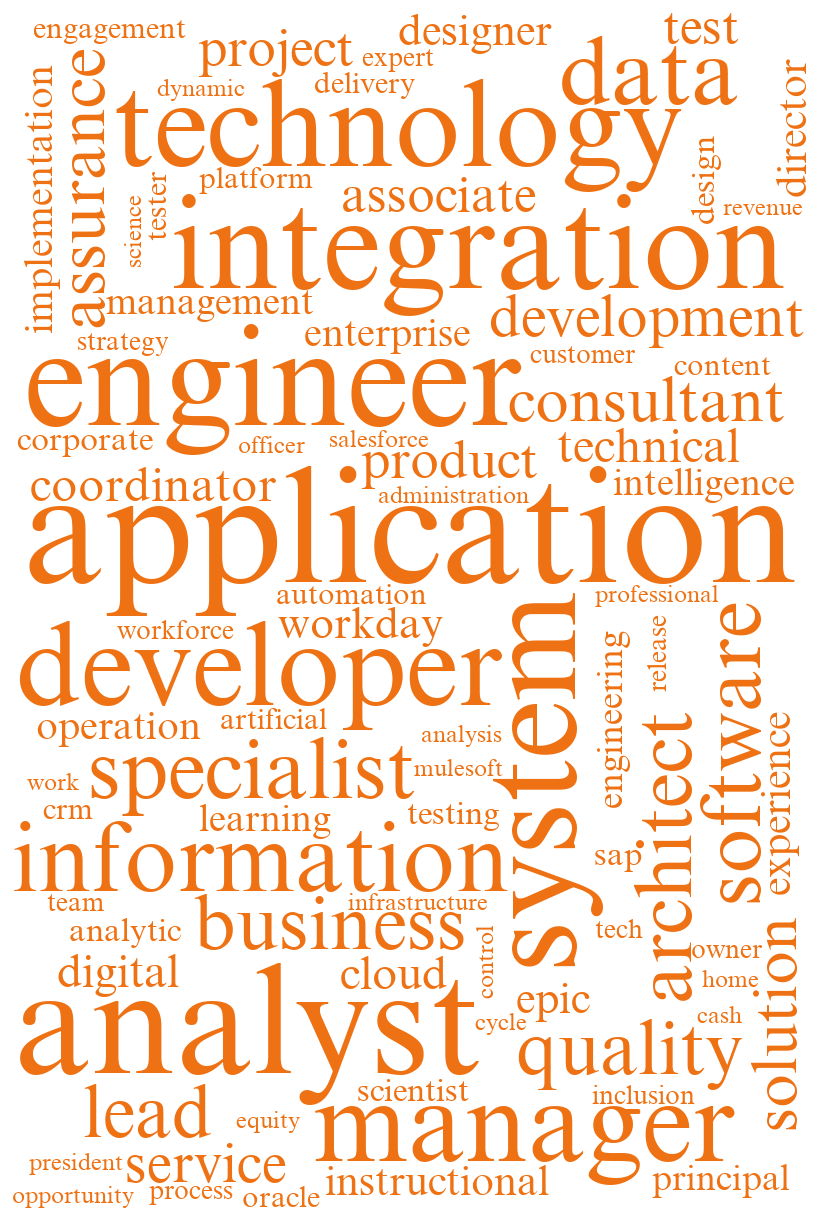

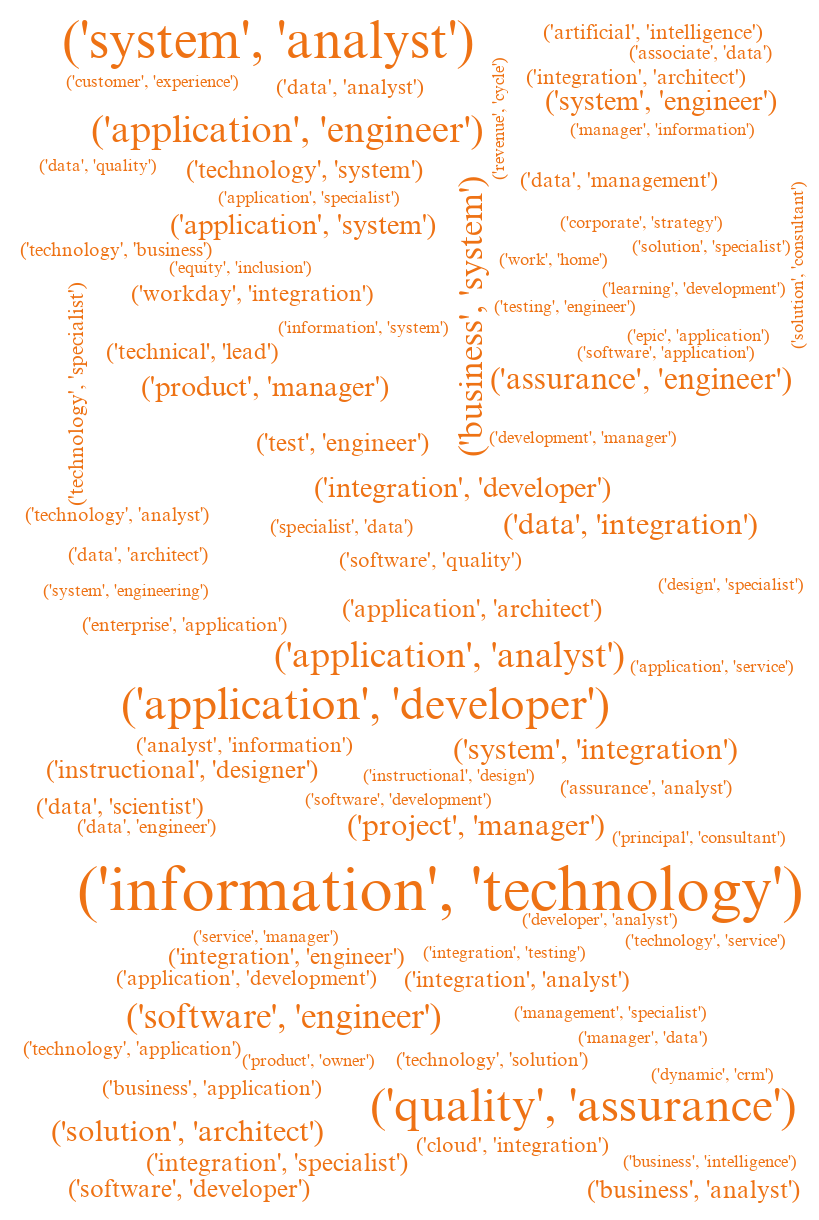

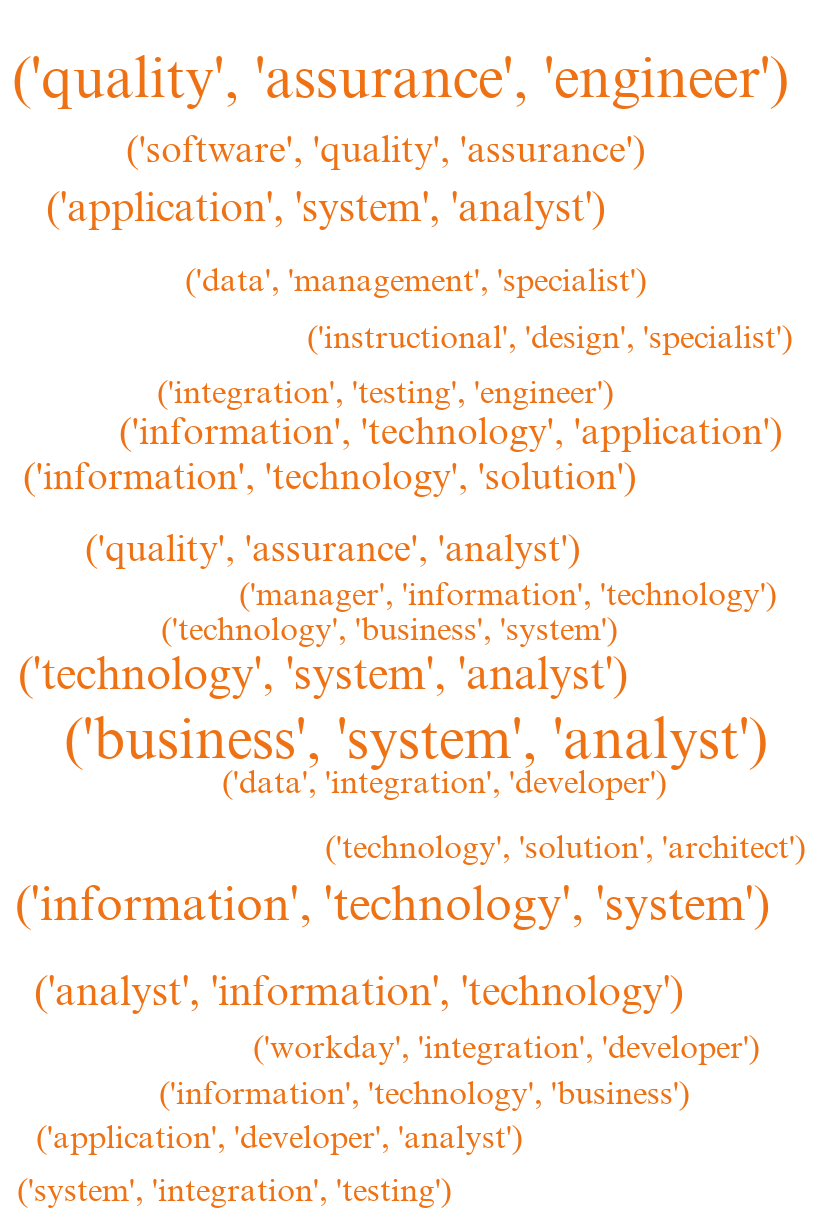

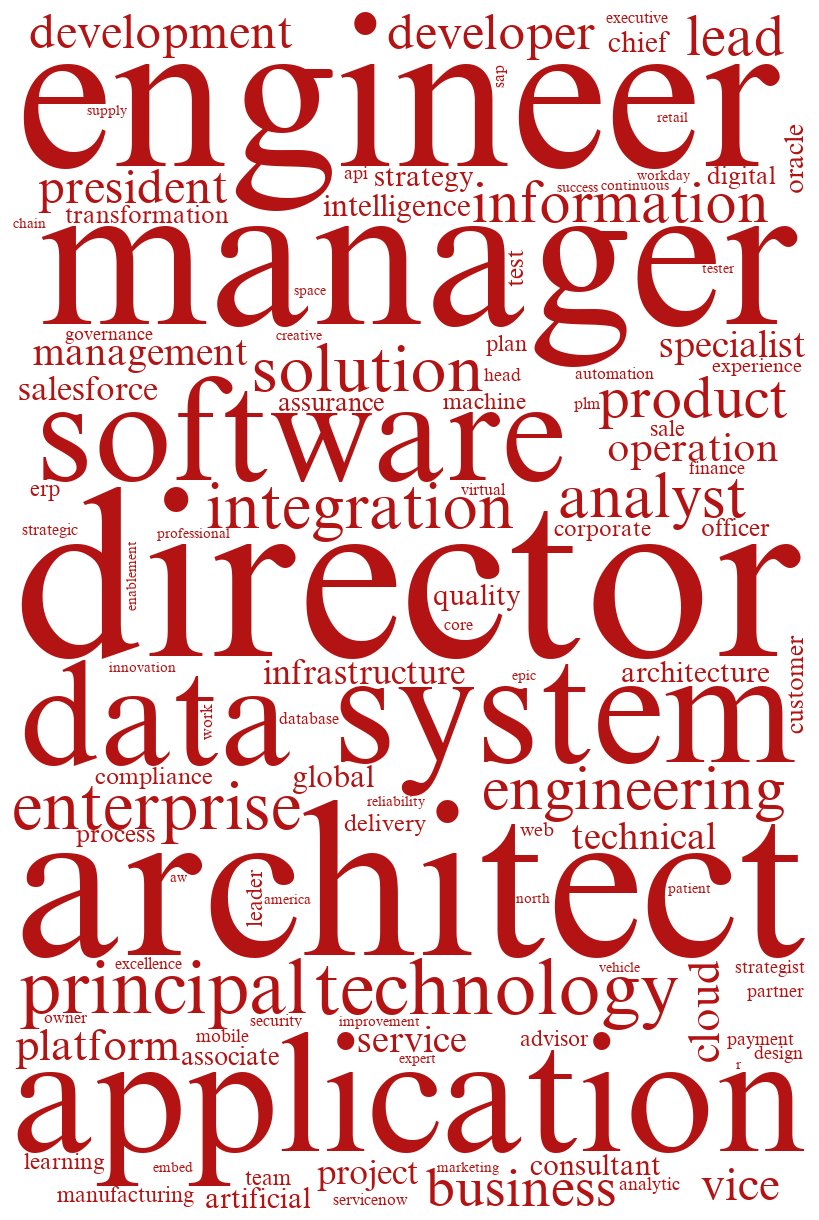

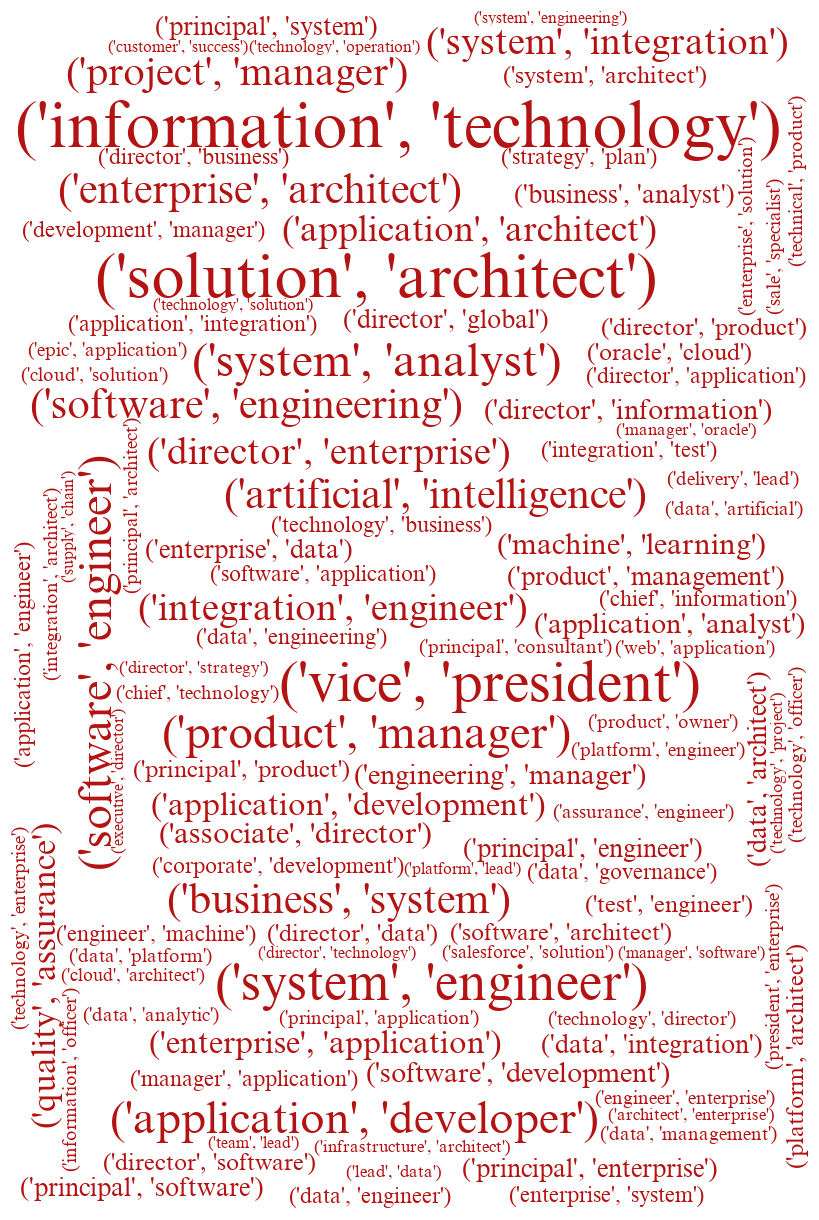

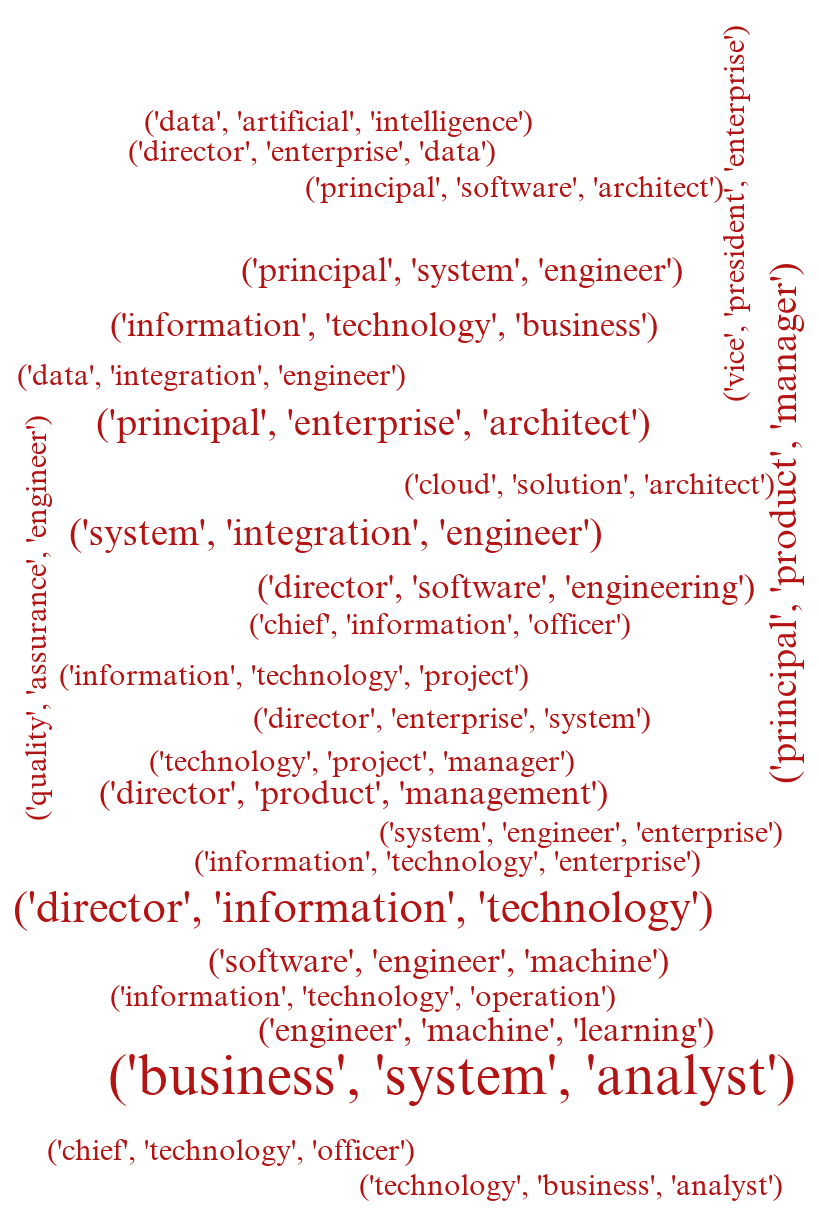

In [35]:
excel_file = pd.ExcelWriter('figures/data/title_freq_ngrams_levels.xlsx', engine='xlsxwriter')

for level in ['junior', 'medior', 'senior']:
    level_df = df[df['level'] == level]
    titles = level_df['title'].tolist()

    # Generate and process n-grams
    for ngram_type, n in [('unigram', 1), ('bigram', 2), ('trigram', 3)]:
        ngrams = get_ngrams(titles, n)
        ngram_freq = Counter(ngrams)

        ngram_freq = {gram: freq for gram, freq in ngram_freq.items() if freq >= 3}
        
        # Create and save wordcloud
        create_wordcloud(dict(ngram_freq), level, ngram_type)

        # Save frequencies to Excel
        save_excel(ngram_freq, level, ngram_type, excel_file)

excel_file.close()